一、目前的預處理步驟
資料讀取與整合

讀取 HDF5 檔案： 從 HDF5 檔中讀取每一個 slide 上的 Visium spot 資料。

資料合併： 將各 slide 的資料合併成一個 DataFrame。

欄位篩選： 根據欄位名稱（例如以 "C" 開頭）選取所有代表細胞型表達的欄位。

Log₂ 轉換與 Outlier 處理

Log₂ 轉換： 為了縮放原始數據並處理 0 值，對每個細胞型的表達值進行 log₂(x+1) 轉換。

IQR Outlier 過濾： 計算轉換後數據的第一四分位 (Q1) 與第三四分位 (Q3)，利用 IQR 方法定義合理數值範圍。

極端值替換： 將在 log₂ 轉換後超出 [Q1 - 1.5×IQR, Q3 + 1.5×IQR] 範圍的離群值，替換成該細胞型非離群值的中位數（或選擇平均值）。

結果存放： 每個細胞型經過處理後的數據存放在新的欄位中（例如 "log2_filtered_C1"、"log2_filtered_C2" 等）。

Z-score 標準化

計算統計參數： 針對每一個已經 log₂ 轉換且已處理離群值的細胞型數據，計算其均值和標準差。

標準化： 利用 (value - mean) / std 將數據轉換為標準化數值，這使得各個細胞型的數據有相同的數值尺度。

參數保存： 儲存每個細胞型的均值和標準差（通常存放在一個字典或 JSON 檔中），以便在模型預測後進行反轉標準化還原到原始尺度。

儲存預處理結果

儲存 CSV： 將整個處理後的 DataFrame 存成 CSV 檔，方便後續模型輸入和結果檢查。

儲存參數： 將 Z-score 標準化的統計參數（均值與標準差）存成 JSON 檔，這將作為後續反轉標準化的重要依據。

二、後續該如何進行
模型訓練

使用預處理後數據： 將上述經過 log₂ 轉換、離群值替換並 Z-score 標準化後的數據作為模型的真實標籤，與對應的 HE 影像和空間座標做整合，構建多模態預測模型。

特徵工程： 除了數值標籤外，可能需要從高解析度的 HE 影像中提取特徵（例如用深度學習模型自動學習特徵），並結合 spot 的空間位置，讓模型能夠捕捉到組織的空間結構。

模型預測與結果還原

預測階段： 模型將根據影像與空間特徵預測每個 spot 中各細胞型的 Z-score 標準化後的表達數值。

反轉 Z-score： 利用之前保存的均值和標準差，將模型預測的 Z-score 乘上標準差並加上均值，還原成處理後的 log₂ 表達值。

反轉 Log₂ 轉換： 使用公式 x = 2^(log₂_value) - 1，將 log₂ 表達值進一步還原到原始表達數值。

結果解讀： 這樣的反轉過程能夠讓你將模型的輸出轉換回具有生物學意義的原始尺度，方便後續解釋和應用。

驗證與評估

視覺化檢查： 在模型訓練和預測過程中，利用直方圖、散點圖等方式對反轉後的數據分布進行檢查，確認預處理與反轉步驟的正確性。

統計檢定： 檢查預測結果與真實標籤之間的相關性（例如用 Spearman 排名相關係數評估），確保模型預測能夠準確捕捉到空間細胞型組成的信息。

最終上傳與應用

提交格式： 根據 Challenge 的要求，最終需要提交處理後還原到原始尺度的預測結果，並確保 spot 與細胞型對應正確。

多階段驗證： 在對模型進行調整時，注意在驗證集上進行多次檢查，確保不同 spot 之間的反轉結果連貫且符合生物學預期。

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# Training data preparation 

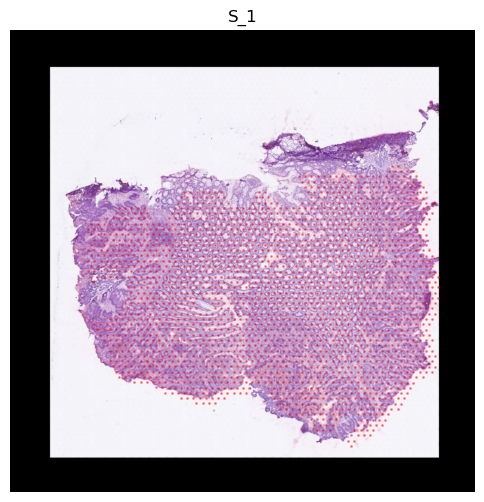

In [2]:
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [3]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,1.009572e-03,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,6.918171e-04,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,9.577447e-05,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,1.964150e-03,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,7.189078e-05,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,1055,701,0.047236,0.112721,0.052490,0.002092,0.000913,0.393805,0.045220,0.013414,...,7.530558e-03,0.559967,0.154793,0.133587,0.000013,0.051041,0.113100,0.003147,0.004971,0.128265
2145,1225,862,0.070764,0.119310,0.193938,0.001239,0.003851,0.588956,0.037731,0.004072,...,3.219223e-02,0.667076,0.094247,0.136623,0.000009,0.050518,0.119685,0.027743,0.016413,0.287171
2146,765,1479,0.194491,0.048068,0.150061,0.002978,0.119206,0.000213,0.005332,0.000078,...,2.628421e-04,0.000273,0.000022,0.000027,0.000042,0.029386,0.019977,0.000039,0.000119,0.006778
2147,607,1525,0.002968,0.151899,0.015931,0.000071,1.354983,0.000152,0.019254,0.001267,...,1.377452e-03,0.003754,0.001420,0.088000,0.000536,0.073240,0.113631,0.009040,0.000090,0.025716


## log 2

In [4]:
import h5py
import numpy as np
import pandas as pd

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # 建立存放各 slide spot 表格的字典：train_spot_tables
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # 從 HDF5 讀取資料並轉換成 NumPy array，再轉換成 DataFrame
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        # 加入 slide_name 欄位，用以日後依照 slide 分組儲存
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")


# ------------------------------
# Step 2: 合併所有 slide 資料，並取得 cell type 欄位 (例如：以 "C" 起始)
# ------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

# 檢查是否有 slide_name 欄位，若沒有則加入 (保險起見)
if "slide_name" not in all_train_spots_df.columns:
    # 這裡假設原本每個 df 都有 slide_name，但若不在 union 中，可以根據索引補回
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")
    
# 假設所有 cell type 欄位皆以 "C" 為開頭，例如 "C1", "C2", ..., "C35"
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

print("Cell Type Abundance 的描述統計:")
print(all_train_spots_df[cell_type_cols].describe())

# -----------------------------------------------------
# Step 3: 定義處理函式：對單一 cell type 欄位進行 log2 轉換，然後利用 IQR 找出極端值，
#         並將極端值以該 cell type 在非極端值的中位數（或平均值）來替換。
# -----------------------------------------------------
def log2_transform_and_clip(series, add_constant=1, factor_low=1.5, factor_high=1.5):
    """
    對一個 Series 進行 log2 轉換，並使用不同的上下界 IQR clip，適合 skewed regression data
    """
    log2_vals = np.log2(series + add_constant)
    
    Q1 = log2_vals.quantile(0.25)
    Q3 = log2_vals.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor_low * IQR
    upper_bound = Q3 + factor_high * IQR

    clipped_vals = log2_vals.clip(lower=lower_bound, upper=upper_bound)

    print(f"{series.name} - Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
    print(f"Lower Bound: {lower_bound:.3f} (×{factor_low}), Upper Bound: {upper_bound:.3f} (×{factor_high})")
    print(f"被 clip 的值數量: {(log2_vals < lower_bound).sum()} (下限), {(log2_vals > upper_bound).sum()} (上限)\n")
    
    return clipped_vals


已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6
Cell Type Abundance 的描述統計:
                C1           C2           C3            C4            C5  \
count  8181.000000  8181.000000  8181.000000  8.181000e+03  8.181000e+03   
mean      1.318803     0.128094     0.910999  5.091857e-01  1.028773e+00   
std       2.977983     0.173881     2.069146  1.190263e+00  1.756582e+00   
min       0.000011     0.000261     0.000085  1.634036e-07  9.356235e-07   
25%       0.016115     0.028555     0.020140  3.504747e-04  6.110887e-03   
50%       0.069115     0.070983     0.066042  4.297313e-03  2.875218e-01   
75%       0.774157     0.156366     0.507187  2.609515e-01  1.131376e+00   
max      29.454552     2.314705    16.949463  9.771889e+00  1.236322e+01   

                 C6           C7            C8            C9           C10  \
count  8.181000e+03  8181.000000  8.181000e+03  8.181000e+03  8.181000e+03   
mean   1.698457e-01     0.050799  1.661383

In [5]:
# 建立新的 DataFrame 存放處理結果
filtered_df = all_train_spots_df.copy()

# 儲存標準化統計參數
zscore_params = {}

for col in cell_type_cols:
    # 1. log2 + IQR clip
    log_clipped = log2_transform_and_clip(all_train_spots_df[col], factor_low=1.0, factor_high=1.5)
    filtered_df[f"log2_filtered_{col}"] = log_clipped
    print(f"🧪 {col} - Log2 + IQR clipped describe():")
    print(log_clipped.describe())
    print("-" * 50)
    # 2. Z-score normalization
    mean_val = log_clipped.mean()
    std_val = log_clipped.std()
    zscore_vals = (log_clipped - mean_val) / std_val

    # 儲存結果
    filtered_df[f"zscore_log2_filtered_{col}"] = zscore_vals
    zscore_params[col] = {"mean": mean_val, "std": std_val}


C1 - Q1: 0.023, Q3: 0.827, IQR: 0.804
Lower Bound: -0.781 (×1.0), Upper Bound: 2.033 (×1.5)
被 clip 的值數量: 0 (下限), 1069 (上限)

🧪 C1 - Log2 + IQR clipped describe():
count    8181.000000
mean        0.520553
std         0.732600
min         0.000015
25%         0.023064
50%         0.096417
75%         0.827134
max         2.033237
Name: C1, dtype: float64
--------------------------------------------------
C2 - Q1: 0.041, Q3: 0.210, IQR: 0.169
Lower Bound: -0.128 (×1.0), Upper Bound: 0.463 (×1.5)
被 clip 的值數量: 0 (下限), 533 (上限)

🧪 C2 - Log2 + IQR clipped describe():
count    8181.000000
mean        0.145765
std         0.133801
min         0.000376
25%         0.040619
50%         0.098935
75%         0.209597
max         0.463065
Name: C2, dtype: float64
--------------------------------------------------
C3 - Q1: 0.029, Q3: 0.592, IQR: 0.563
Lower Bound: -0.534 (×1.0), Upper Bound: 1.436 (×1.5)
被 clip 的值數量: 0 (下限), 1209 (上限)

🧪 C3 - Log2 + IQR clipped describe():
count    8181.000000
mean  

### Use smoothed data to do z-score

In [88]:
with h5py.File("./dataset/gu_smooth_processed_train_spots_log2.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # 建立存放各 slide spot 表格的字典：train_spot_tables
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # 從 HDF5 讀取資料並轉換成 NumPy array，再轉換成 DataFrame
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        # 加入 slide_name 欄位，用以日後依照 slide 分組儲存
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")


# ------------------------------
# Step 2: 合併所有 slide 資料，並取得 cell type 欄位 (例如：以 "C" 起始)
# ------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

# 檢查是否有 slide_name 欄位，若沒有則加入 (保險起見)
if "slide_name" not in all_train_spots_df.columns:
    # 這裡假設原本每個 df 都有 slide_name，但若不在 union 中，可以根據索引補回
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")
    
# 假設所有 cell type 欄位皆以 "C" 為開頭，例如 "C1", "C2", ..., "C35"
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("log2_filtered_")]

print("Cell Type Abundance 的描述統計:")
print(all_train_spots_df[cell_type_cols].describe())
# 建立新的 DataFrame 存放處理結果
filtered_df = all_train_spots_df.copy()

# 儲存標準化統計參數
zscore_params = {}

for col in cell_type_cols:
    # 1. log2 + IQR clip
    print(filtered_df[col].describe())
    # 2. Z-score normalization
    mean_val = filtered_df[col].mean()
    std_val = filtered_df[col].std()
    zscore_vals = (filtered_df[col] - mean_val) / std_val

    # 儲存結果
    filtered_df[f"zscore_{col}"] = zscore_vals
    zscore_params[col] = {"mean": mean_val, "std": std_val}

已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6
Cell Type Abundance 的描述統計:
       log2_filtered_C1  log2_filtered_C2  log2_filtered_C3  log2_filtered_C4  \
count       8181.000000       8181.000000       8181.000000       8181.000000   
mean           0.520771          0.145652          0.385499          0.209272   
std            0.674071          0.102318          0.479354          0.298624   
min            0.000183          0.002685          0.000893          0.000003   
25%            0.060654          0.065609          0.058627          0.004732   
50%            0.141117          0.119098          0.122782          0.020355   
75%            0.795010          0.207130          0.577065          0.424285   
max            2.033237          0.461092          1.436495          0.835524   

       log2_filtered_C5  log2_filtered_C6  log2_filtered_C7  log2_filtered_C8  \
count       8181.000000       8181.000000       8181.000000      8.18100

In [89]:
filtered_df

,x,y,log2_filtered_C1,log2_filtered_C2,log2_filtered_C3,log2_filtered_C4,log2_filtered_C5,log2_filtered_C6,log2_filtered_C7,log2_filtered_C8,...,zscore_log2_filtered_C26,zscore_log2_filtered_C27,zscore_log2_filtered_C28,zscore_log2_filtered_C29,zscore_log2_filtered_C30,zscore_log2_filtered_C31,zscore_log2_filtered_C32,zscore_log2_filtered_C33,zscore_log2_filtered_C34,zscore_log2_filtered_C35
0,1554,1297,0.143505,0.075235,0.089927,0.015730,0.629734,0.207024,0.023413,0.005767,...,-0.031905,1.815745,0.702708,-0.180945,-0.512737,-0.728829,-0.695680,0.578120,-0.358010,-0.545869
1,462,1502,0.431163,0.254448,0.349307,0.036537,1.647564,0.002184,0.072502,0.005755,...,0.277056,-0.673069,-0.646595,0.503760,-0.421155,1.116232,0.547998,0.178392,0.041151,0.118225
2,1488,1548,0.236230,0.065074,0.130901,0.027519,1.217376,0.053459,0.026325,0.000864,...,-0.789862,0.435546,-0.758878,-0.386249,-0.635466,-0.747592,-0.883367,-0.700878,-0.896290,-0.858110
3,1725,1182,0.041216,0.175927,0.066720,0.023251,2.505798,0.084257,0.118813,0.005542,...,-0.878014,0.154293,-0.729320,1.198074,-0.739087,0.053229,-0.063933,-0.105303,-0.869058,0.051120
4,581,1113,0.039867,0.051347,0.037370,0.014531,1.644752,0.000768,0.033427,0.000793,...,-1.050966,-0.656604,-0.957773,-0.471858,-0.716029,-0.864885,-1.004887,-1.163478,-1.016230,-0.974591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,1173,842,0.208901,0.142022,0.066338,0.004613,2.196273,0.000693,0.072117,0.005637,...,-0.160570,-0.375415,-0.644158,0.033540,-0.277909,-0.162667,-0.475918,0.187382,-0.722449,-0.511431
8177,1237,775,0.067562,0.060331,0.041611,0.003617,1.173163,0.000194,0.024616,0.002732,...,-0.700942,-0.659993,-0.860771,-0.227348,-0.307181,-0.831091,-0.961476,-0.193561,-0.921899,-0.977348
8178,903,953,0.017118,0.038181,0.026807,0.015715,0.141556,0.001374,0.010687,0.000709,...,-0.300100,-0.713173,-0.970321,-0.769203,-0.593240,-1.023827,-1.106464,0.120244,-0.981754,-1.075038
8179,954,1310,0.022722,0.168614,0.049221,0.003986,2.496426,0.006871,0.111926,0.004945,...,-0.597380,-0.641030,-0.780307,0.810035,-0.611057,-0.030108,-0.341093,0.609460,-0.836955,-0.389296


In [90]:
# -----------------------------------------------------
# Step 5: 檢查處理後的結果
# -----------------------------------------------------
print("處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):")
zscore_cols = ["zscore_" + col for col in cell_type_cols]
print(filtered_df[zscore_cols].describe())

# 若需要，你也可以將 zscore_params 存下來，以便後續反轉標準化
print("Z-score 標準化的統計參數 (每個 cell type):")
for col, params in zscore_params.items():
    print(f"{col}: mean = {params['mean']:.3f}, std = {params['std']:.3f}")


處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):
       zscore_log2_filtered_C1  zscore_log2_filtered_C2  \
count              8181.000000             8.181000e+03   
mean                  0.000000             5.558579e-17   
std                   1.000000             1.000000e+00   
min                  -0.772305            -1.397277e+00   
25%                  -0.682595            -7.822980e-01   
50%                  -0.563225            -2.595193e-01   
75%                   0.406840             6.008566e-01   
max                   2.243781             3.082951e+00   

       zscore_log2_filtered_C3  zscore_log2_filtered_C4  \
count             8.181000e+03             8.181000e+03   
mean              5.558579e-17            -5.558579e-17   
std               1.000000e+00             1.000000e+00   
min              -8.023401e-01            -7.007778e-01   
25%              -6.818993e-01            -6.849441e-01   
50%              -5.480638e-01            -6.326275e-01   
75%    

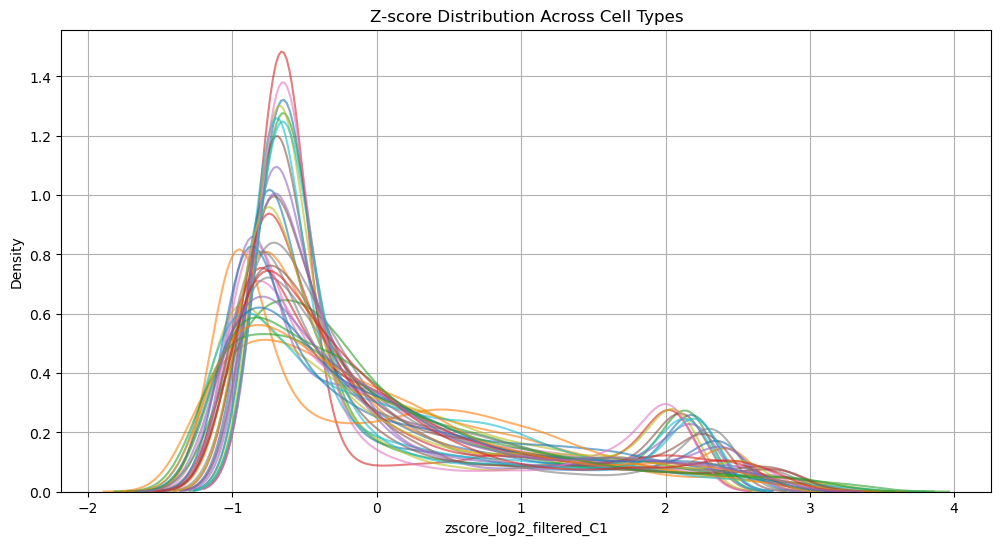

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
cell_type_cols = [col for col in filtered_df.columns if col.startswith("zscore_log2_filtered_")]

plt.figure(figsize=(12, 6))
for col in cell_type_cols[:35]:  # 前10個看看
    sns.kdeplot(filtered_df[f"{col}"], label=col, alpha=0.6)

plt.title("Z-score Distribution Across Cell Types")
#plt.legend()
plt.grid(True)
plt.show()


In [87]:
for col, params in zscore_params.items():
    print(f"{col}: mean = {params['mean']:.3f}, std = {params['std']:.3f}")

log2_filtered_C1: mean = 0.521, std = 0.674
log2_filtered_C2: mean = 0.146, std = 0.102
log2_filtered_C3: mean = 0.385, std = 0.479
log2_filtered_C4: mean = 0.209, std = 0.299
log2_filtered_C5: mean = 0.689, std = 0.735
log2_filtered_C6: mean = 0.062, std = 0.081
log2_filtered_C7: mean = 0.060, std = 0.052
log2_filtered_C8: mean = 0.007, std = 0.006
log2_filtered_C9: mean = 0.170, std = 0.232
log2_filtered_C10: mean = 0.016, std = 0.021
log2_filtered_C11: mean = 0.011, std = 0.013
log2_filtered_C12: mean = 0.030, std = 0.029
log2_filtered_C13: mean = 0.005, std = 0.004
log2_filtered_C14: mean = 0.039, std = 0.035
log2_filtered_C15: mean = 0.088, std = 0.105
log2_filtered_C16: mean = 0.614, std = 0.706
log2_filtered_C17: mean = 0.138, std = 0.144
log2_filtered_C18: mean = 0.087, std = 0.089
log2_filtered_C19: mean = 0.045, std = 0.040
log2_filtered_C20: mean = 0.069, std = 0.056
log2_filtered_C21: mean = 0.032, std = 0.032
log2_filtered_C22: mean = 0.020, std = 0.019
log2_filtered_C23: 

## Save data

In [93]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/version-4/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "gu_zscore_processed_train_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/log2_Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in filtered_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位
        cols_to_save = ["x", "y"] + [col for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'zscore_log2_filtered_C1', 'zscore_log2_filtered_C2', 'zscore_log2_filtered_C3', 'zscore_log2_filtered_C4', 'zscore_log2_filtered_C5', 'zscore_log2_filtered_C6', 'zscore_log2_filtered_C7', 'zscore_log2_filtered_C8', 'zscore_log2_filtered_C9', 'zscore_log2_filtered_C10', 'zscore_log2_filtered_C11', 'zscore_log2_filtered_C12', 'zscore_log2_filtered_C13', 'zscore_log2_filtered_C14', 'zscore_log2_filtered_C15', 'zscore_log2_filtered_C16', 'zscore_log2_filtered_C17', 'zscore_log2_filtered_C18', 'zscore_log2_filtered_C19', 'zscore_log2_filtered_C20', 'zscore_log2_filtered_C21', 'zscore_log2_filtered_C22', 'zscore_log2_filtered_C23', 'zscore_log2_filtered_C24', 'zscore_log2_filtered_C25', 'zscore_log2_filtered_C26', 'zscore_log2_filtered_C27', 'zscore_log2_filtered_C28', 'zscore_log2_filtered_C29', 'zscore_log2_filtered_C30', 'zscore_log2_filtered

In [94]:
import json
# -----------------------------------------------------
output_file = os.path.join(save_folder, "zscore_params.json")

# 儲存 zscore_params 字典為 JSON 檔 (便於後續還原標準化)
with open(output_file, "w") as f:
    json.dump(zscore_params, f, indent=4)
print("儲存 Z-score 標準化統計參數到 'zscore_params.json'")

儲存 Z-score 標準化統計參數到 'zscore_params.json'


### see plots

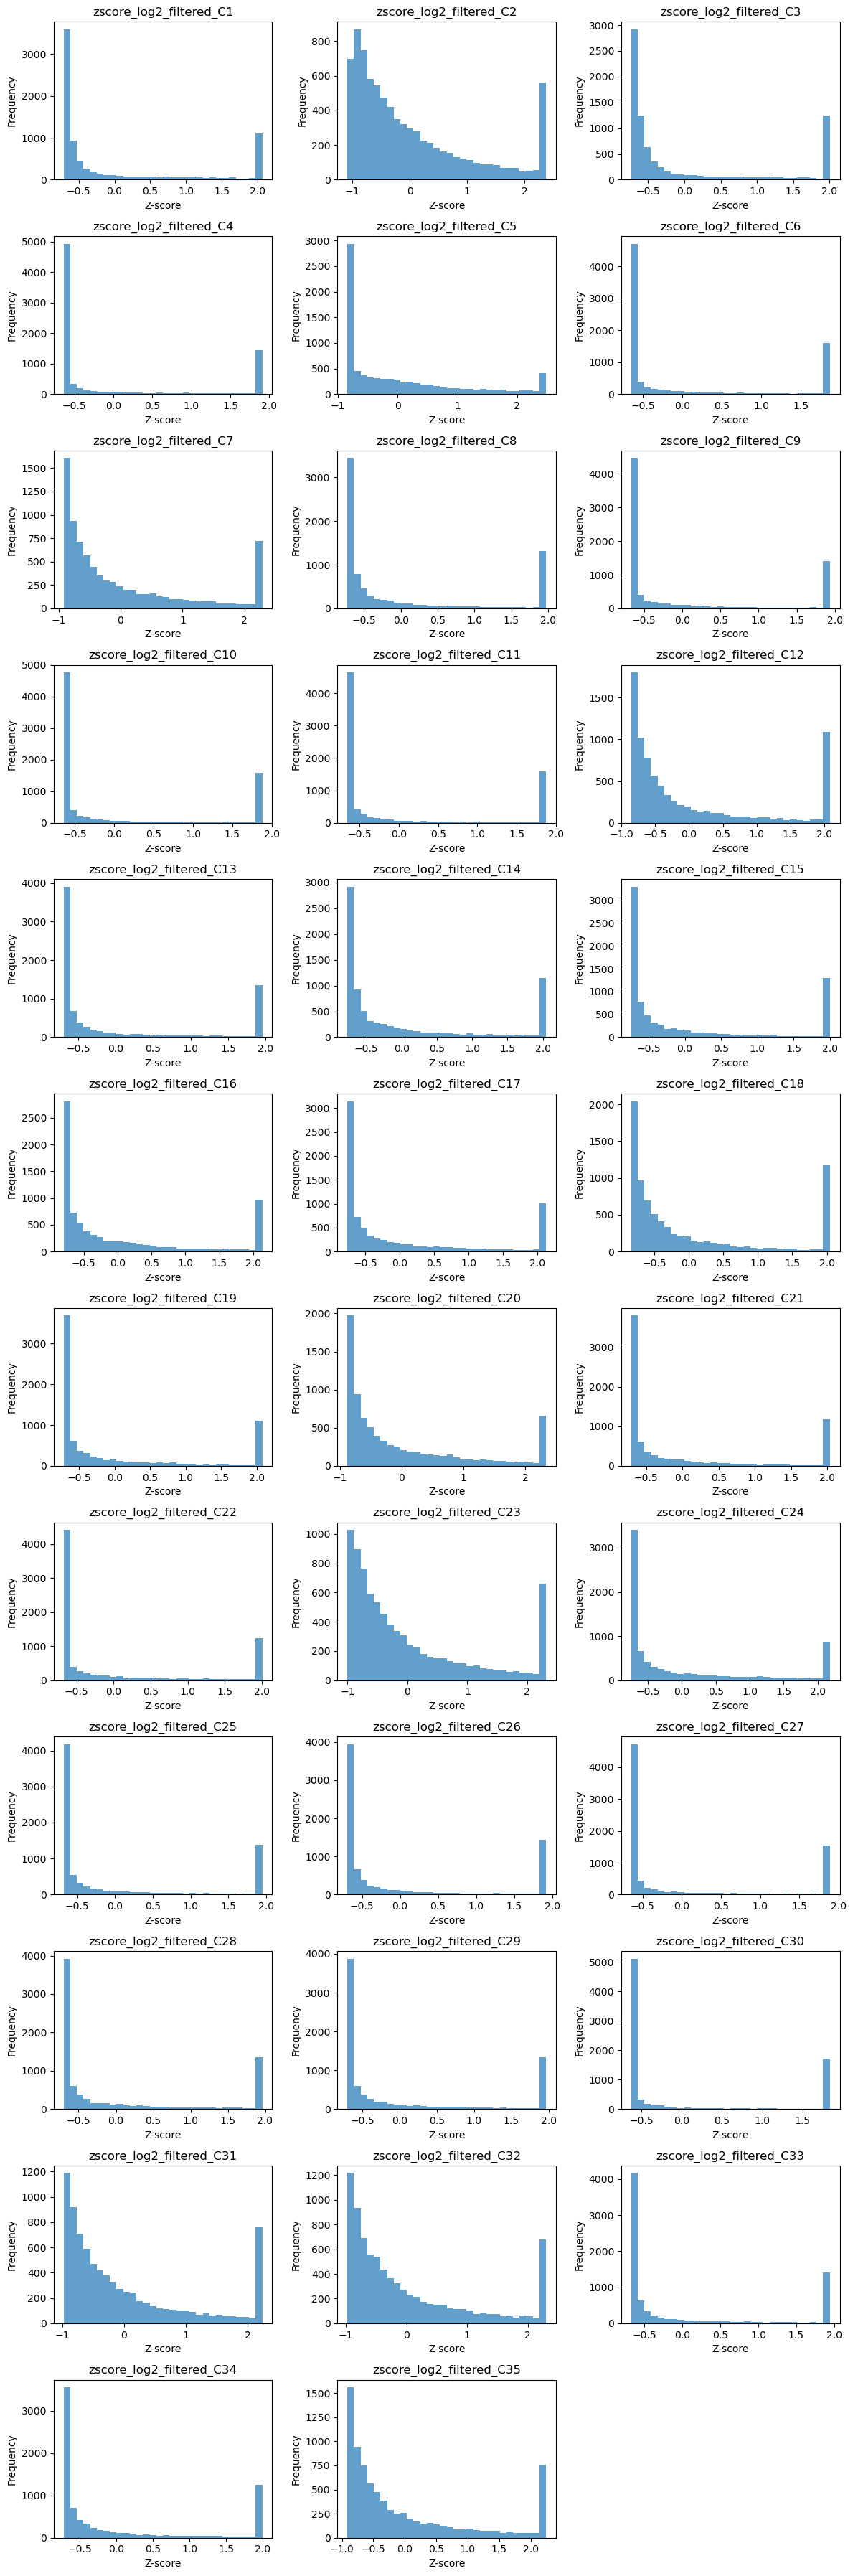

In [103]:
import matplotlib.pyplot as plt

# 取得所有經過 Z-score 標準化後的欄位名稱
zscore_cols = ["zscore_log2_filtered_" + col for col in cell_type_cols]

# 設定圖表排版: 例如每排顯示 3 個子圖
ncols = 3
nrows = (len(zscore_cols) // ncols) + (1 if len(zscore_cols) % ncols else 0)

# 建立圖表與子圖，設定圖表大小
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()  # 攤平成一維陣列，方便用迴圈操作

for i, col in enumerate(zscore_cols):
    ax = axes[i]
    # 取出每個 cell type 經標準化後的數據
    data = filtered_df[col]
    
    # 畫 histogram，bin 數根據資料分布可做調整 (這裡預設 30 個 bin)
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Z-score")
    ax.set_ylabel("Frequency")
    
# 如果有多餘的子圖，將其移除
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
fig.tight_layout()
plt.show()


## Box-Cox

In [10]:
from scipy.stats import boxcox, boxcox_normmax
from scipy.special import inv_boxcox

def boxcox_transform_and_clip(series, add_constant=1e-3, factor_low=1.5, factor_high=1.5):
    """
    對 Series 做 Box-Cox 轉換並 clip outliers，並儲存 lambda 以便還原。
    """
    x = series + add_constant  # 避免 0
    x = x.values if isinstance(x, pd.Series) else x

    # ✅ 找最佳 λ
    best_lambda = boxcox_normmax(x, method='mle')

    # ✅ 做 Box-Cox 轉換
    x_boxcox = boxcox(x, lmbda=best_lambda)

    # ✅ IQR clip（在 Box-Cox 空間做）
    Q1 = np.quantile(x_boxcox, 0.25)
    Q3 = np.quantile(x_boxcox, 0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor_low * IQR
    upper_bound = Q3 + factor_high * IQR

    clipped_vals = np.clip(x_boxcox, lower_bound, upper_bound)

    print(f"{series.name} - λ: {best_lambda:.4f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
    print(f"Clip: [{lower_bound:.3f}, {upper_bound:.3f}] → clipped {np.sum(x_boxcox < lower_bound)} (low), {np.sum(x_boxcox > upper_bound)} (high)\n")

    return clipped_vals, best_lambda


# 儲存處理結果與 lambda 值
boxcox_zscore_params = {}
add_constant = 1.0  # 可以根據你當時用的設定改

for col in cell_type_cols:
    # 1. 做 Box-Cox + IQR clip
    boxcox_clipped, lam = boxcox_transform_and_clip(
        all_train_spots_df[col],
        add_constant=add_constant,
        factor_low=1.0,
        factor_high=1.5
    )

    filtered_df[f"boxcox_filtered_{col}"] = boxcox_clipped

    # 2. 做 Z-score
    mean_val = float(boxcox_clipped.mean())  # 轉成 native float
    std_val = float(boxcox_clipped.std())
    zscore_vals = (boxcox_clipped - mean_val) / std_val

    filtered_df[f"zscore_boxcox_filtered_{col}"] = zscore_vals

    # 3. 儲存所有還原參數（lambda + z-score + add）
    boxcox_zscore_params[col] = {
        "lambda": float(lam),  # 確保能 json 存
        "mean": mean_val,
        "std": std_val,
        "add_constant": add_constant
    }

    # ✅ Debug 輸出
    print(f"✅ {col} done. λ={lam:.4f}, mean={mean_val:.4f}, std={std_val:.4f}")
    print("-" * 40)


C1 - λ: -1.8179, Q1: 0.016, Q3: 0.356, IQR: 0.340
Clip: [-0.325, 0.867] → clipped 0 (low), 0 (high)

✅ C1 done. λ=-1.8179, mean=0.1748, std=0.1990
----------------------------------------
C2 - λ: -6.8555, Q1: 0.026, Q3: 0.092, IQR: 0.066
Clip: [-0.041, 0.192] → clipped 0 (low), 0 (high)

✅ C2 done. λ=-6.8555, mean=0.0609, std=0.0402
----------------------------------------
C3 - λ: -2.2817, Q1: 0.019, Q3: 0.266, IQR: 0.247
Clip: [-0.227, 0.637] → clipped 0 (low), 0 (high)

✅ C3 done. λ=-2.2817, mean=0.1405, std=0.1548
----------------------------------------
C4 - λ: -3.2809, Q1: 0.000, Q3: 0.162, IQR: 0.162
Clip: [-0.162, 0.405] → clipped 0 (low), 0 (high)

✅ C4 done. λ=-3.2809, mean=0.0793, std=0.1154
----------------------------------------
C5 - λ: -1.3373, Q1: 0.006, Q3: 0.476, IQR: 0.470
Clip: [-0.464, 1.181] → clipped 0 (low), 0 (high)

✅ C5 done. λ=-1.3373, mean=0.2607, std=0.2449
----------------------------------------
C6 - λ: -7.2353, Q1: 0.000, Q3: 0.053, IQR: 0.053
Clip: [-0.

處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):
       zscore_boxcox_filtered_C1  zscore_boxcox_filtered_C2  \
count               8.181000e+03               8.181000e+03   
mean                5.558579e-17               9.032691e-17   
std                 1.000061e+00               1.000061e+00   
min                -8.784205e-01              -1.510366e+00   
25%                -7.992975e-01              -8.791803e-01   
50%                -5.622561e-01              -1.542683e-01   
75%                 9.108257e-01               7.741379e-01   
max                 1.880056e+00               2.114973e+00   

       zscore_boxcox_filtered_C3  zscore_boxcox_filtered_C4  \
count               8.181000e+03               8.181000e+03   
mean               -5.558579e-17              -1.111716e-16   
std                 1.000061e+00               1.000061e+00   
min                -9.071417e-01              -6.871796e-01   
25%                -7.817975e-01              -6.841467e-01   
50%   

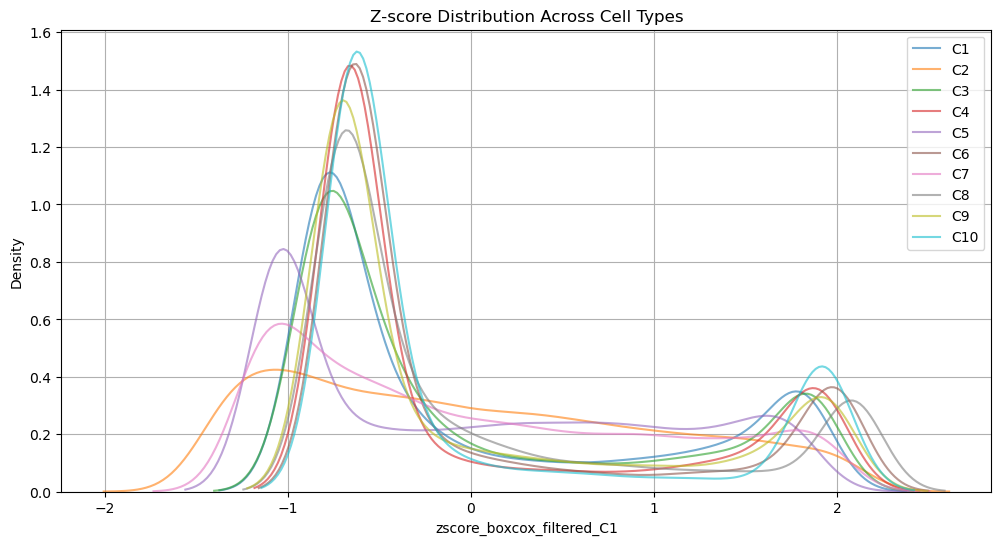

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# -----------------------------------------------------
# Step 5: 檢查處理後的結果
# -----------------------------------------------------
print("處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):")
zscore_cols = ["zscore_boxcox_filtered_" + col for col in cell_type_cols]
print(filtered_df[zscore_cols].describe())

# 若需要，你也可以將 zscore_params 存下來，以便後續反轉標準化
print("Z-score 標準化的統計參數 (每個 cell type):")
for col, params in boxcox_zscore_params.items():
    print(f"{col}: mean = {params['mean']:.3f}, std = {params['std']:.3f}")

plt.figure(figsize=(12, 6))
for col in cell_type_cols[:10]:  # 前10個看看
    sns.kdeplot(filtered_df[f"zscore_boxcox_filtered_{col}"], label=col, alpha=0.6)

plt.title("Z-score Distribution Across Cell Types")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("./dataset/gu_smooth_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # 建立存放各 slide spot 表格的字典：train_spot_tables
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # 從 HDF5 讀取資料並轉換成 NumPy array，再轉換成 DataFrame
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        # 加入 slide_name 欄位，用以日後依照 slide 分組儲存
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")


# ------------------------------
# Step 2: 合併所有 slide 資料，並取得 cell type 欄位 (例如：以 "C" 起始)
# ------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# -----------------------------------------------------
# Step 5: 檢查處理後的結果
# -----------------------------------------------------
print("處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):")
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("zscore_log2_filtered_")]

print(all_train_spots_df[cell_type_cols].describe())

plt.figure(figsize=(12, 6))
for col in cell_type_cols[:35]:  # 前10個看看
    sns.kdeplot(all_train_spots_df[col], label=col, alpha=0.6)

plt.title("Z-score Distribution Across Cell Types")
plt.legend()
plt.grid(True)
plt.show()


處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):


ValueError: Cannot describe a DataFrame without columns

In [12]:
import json

# 儲存 JSON
with open("./dataset/boxcox_zscore_params.json", "w") as f:
    json.dump(boxcox_zscore_params, f, indent=4)

print("✅ 已儲存完整轉換參數至 boxcox_zscore_params.json")



✅ 已儲存完整轉換參數至 boxcox_zscore_params.json


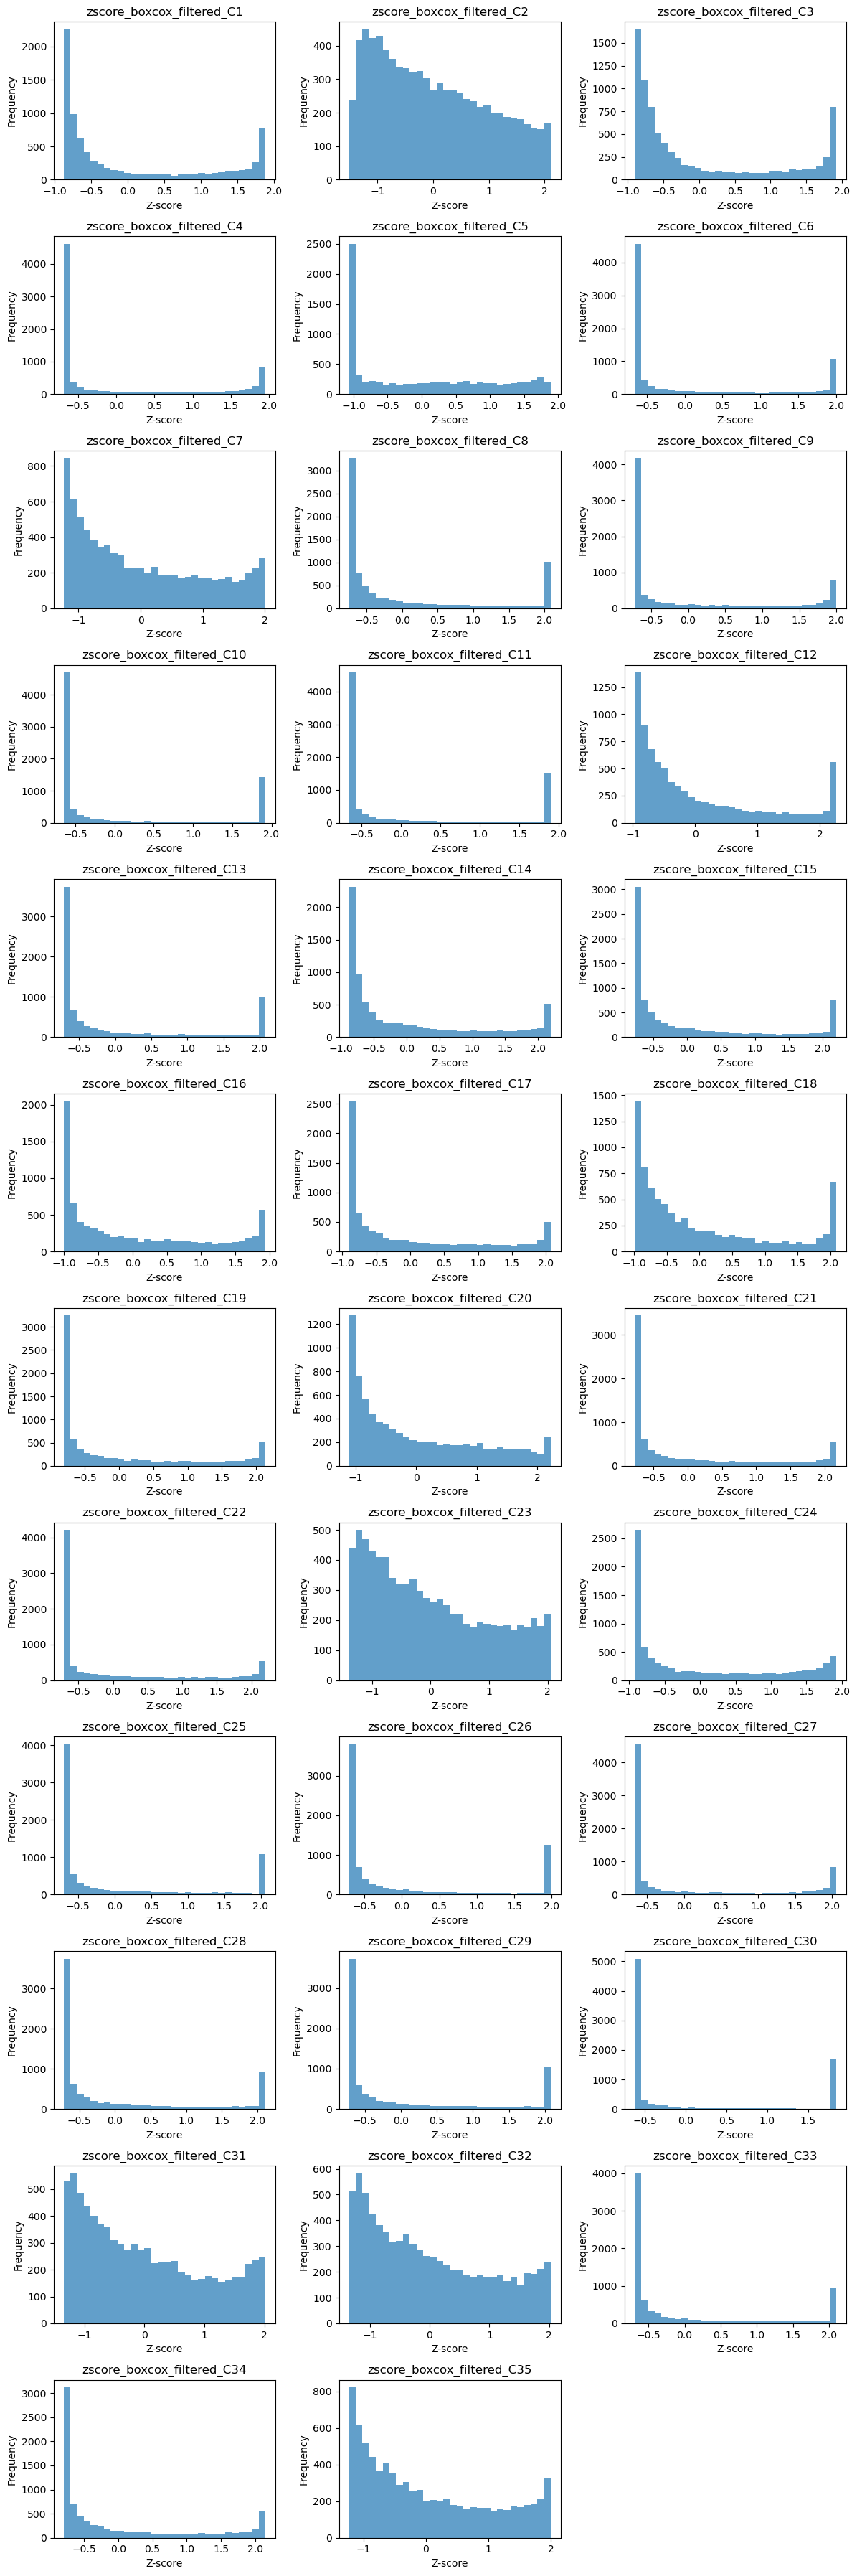

In [125]:
import matplotlib.pyplot as plt

# 取得所有經過 Z-score 標準化後的欄位名稱
zscore_cols = ["zscore_boxcox_filtered_" + col for col in cell_type_cols]

# 設定圖表排版: 例如每排顯示 3 個子圖
ncols = 3
nrows = (len(zscore_cols) // ncols) + (1 if len(zscore_cols) % ncols else 0)

# 建立圖表與子圖，設定圖表大小
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()  # 攤平成一維陣列，方便用迴圈操作

for i, col in enumerate(zscore_cols):
    ax = axes[i]
    # 取出每個 cell type 經標準化後的數據
    data = filtered_df[col]
    
    # 畫 histogram，bin 數根據資料分布可做調整 (這裡預設 30 個 bin)
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Z-score")
    ax.set_ylabel("Frequency")
    
# 如果有多餘的子圖，將其移除
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
fig.tight_layout()
plt.show()


# Revert z-score back to original to compare

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

In [ ]:
from python_scripts.revert_utils import load_json_params

def compare_raw_vs_processed_cell_expression(
    slide_id,                      # 例如 "S_7"
    cell_type,                     # 原始欄位名稱，例如 "C17"
    raw_spot_path,                 # 原始資料 HDF5 檔案，例如 "./dataset/elucidata_ai_challenge_data.h5"
    raw_group,                     # 原始資料的 spot group，例如 "spots/Train" 或 "spots/Test"
    processed_spot_path,           # 處理後資料 HDF5 檔案，例如 "dataset/spots-data/version-4/gu_zscore_processed_train_spots.h5"
    processed_group,               # 處理後資料的 spot group，例如 "spots/log2_Train"
    processed_cell_prefix,
    zscore_params,                 # 轉換參數字典（透過 load_json_params 載入）
    image_path,                    # 影像 HDF5 檔案，例如 "./dataset/elucidata_ai_challenge_data.h5"
    image_group,                   # 圖像所在 group，例如 "images/Train" 或 "images/Test"
    add_constant=1.0               # 轉換時用的 add_constant，預設 1.0
):
    """
    比較指定 slide 上同一 cell_type 在 raw 資料與 processed→raw 還原資料的 expression map。

    參數：
      slide_id: 要繪圖的 slide 名稱（例如 "S_7"）
      cell_type: 原始 cell type 欄位名稱（例如 "C17"）
      raw_spot_path: 包含 raw spot 資料的 HDF5 檔案路徑
      raw_group: 原始資料中的 group 路徑（例如 "spots/Train"）
      processed_spot_path: 處理過的 spot 資料 HDF5 檔案路徑
      processed_group: 處理過的資料 group（例如 "spots/log2_Train"）
      zscore_params: 包含各 cell type Z-score 還原參數的 dict
      image_path: 含有影像資料的 HDF5 檔案路徑
      image_group: 影像所在 group（例如 "images/Train"）
      add_constant: log2 轉換時使用的常數（預設 1.0）

    返回：
      直接繪製一個圖形，左圖為 raw 表達量，右圖為從 processed 還原後的表達量。
    """
    import h5py
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # ---------- 讀取影像 ----------
    with h5py.File(image_path, "r") as h5file:
        image = np.array(h5file[f"images/{image_group}"][slide_id])

    # ---------- 讀取 raw spot 資料 ----------
    with h5py.File(raw_spot_path, "r") as f:
        raw_spots = np.array(f[f"{raw_group}"][slide_id])
    df_raw = pd.DataFrame(raw_spots)
    # 假設 raw 資料的欄位名稱就是 cell_type (例如 "C17")
    if cell_type not in df_raw.columns:
        raise ValueError(f"Raw data: Cell type '{cell_type}' not found!")
    raw_expr = df_raw[cell_type].values
    # 取座標
    x = df_raw["x"].values
    y = df_raw["y"].values

    # ---------- 讀取 processed spot 資料 ----------
    with h5py.File(processed_spot_path, "r") as f:
        proc_spots = np.array(f[f"{processed_group}"][slide_id])
    df_proc = pd.DataFrame(proc_spots)
    # processed data的欄位名稱為 cell_prefix + cell_type
    full_col_name = processed_cell_prefix + cell_type
    if full_col_name not in df_proc.columns:
        raise ValueError(f"Processed data: Cell type '{full_col_name}' not found!")
    proc_expr = df_proc[full_col_name].values

    # ---------- 還原 processed 資料到 raw scale ----------
    # 定義一個輔助函數 inline
    def revert_processed(processed_val, cell, zscore_params, add_constant=1.0):
        mean = zscore_params[cell]["mean"]
        std = zscore_params[cell]["std"]
        # 還原 log2: processed_val 是 zscore，轉換過程：log2_val = zscore * std + mean, raw = 2^(log2_val) - add_constant
        log2_val = processed_val * std + mean
        raw_val = np.power(2, log2_val) - add_constant
        return raw_val

    reverted_expr = revert_processed(proc_expr, cell_type, zscore_params, add_constant=add_constant)

    # ---------- 畫圖：左右各一幅比較 ----------
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 左圖：Raw 表達量
    ax0 = axes[0]
    ax0.imshow(image, aspect='auto')
    sc0 = ax0.scatter(x, y, c=raw_expr, cmap='plasma', s=15, alpha=0.8)
    ax0.set_title(f"Raw Expression: {cell_type}")
    ax0.axis('off')
    cbar0 = plt.colorbar(sc0, ax=ax0)
    cbar0.set_label("Raw")
    # 右圖：還原後的 Processed 表達量
    ax1 = axes[1]
    ax1.imshow(image, aspect='auto')
    sc1 = ax1.scatter(x, y, c=reverted_expr, cmap='plasma', s=15, alpha=0.8)
    ax1.set_title(f"Reverted Processed: {full_col_name}")
    ax1.axis('off')
    cbar1 = plt.colorbar(sc1, ax=ax1)
    cbar1.set_label("Reverted")
    import pandas as pd

    # 將 raw_expr 和 reverted_expr 轉成 pandas Series 並計算描述性統計
    raw_desc = pd.Series(raw_expr).describe()
    reverted_desc = pd.Series(reverted_expr).describe()

    # 合併成一個 DataFrame, 每一個統計量為 index，兩個欄位分別為 Raw 與 Reverted
    desc_df = pd.concat([raw_desc, reverted_desc], axis=1)
    desc_df.columns = ['Raw', 'Reverted']

    print(desc_df)

    plt.suptitle(f"Comparison of Raw vs. Reverted Processed Expression for {cell_type} on {slide_id}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


                Raw     Reverted
count  2.149000e+03  2149.000000
mean   8.578307e-03     0.003101
std    3.121902e-02     0.002171
min    2.295143e-08     0.000029
25%    5.280422e-05     0.001498
50%    3.931743e-04     0.002651
75%    3.348605e-03     0.004113
max    6.598890e-01     0.012514


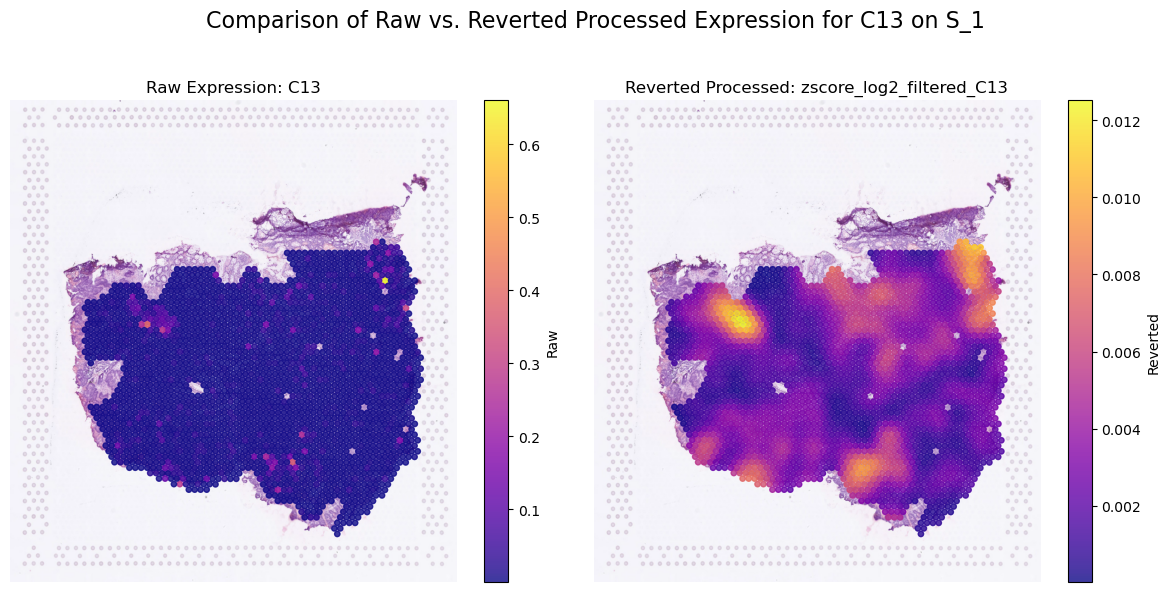

In [29]:
zscore_params = load_json_params('dataset/spots-data/version-4/zscore_params.json')
compare_raw_vs_processed_cell_expression(
    slide_id="S_1",
    cell_type="C13",
    raw_spot_path="dataset/filtered&masked_dataset.h5",
    raw_group="spots/Train",
    processed_spot_path="dataset/spots-data/version-4/gu_zscore_processed_train_spots.h5",
    processed_group="spots/log2_Train",
    processed_cell_prefix = 'zscore_log2_filtered_',
    zscore_params=zscore_params,
    image_path="./dataset/elucidata_ai_challenge_data.h5",
    image_group="Train",
    add_constant=1.0
)